
# NMT-Keras tutorial
---

This notebook describes, step by step, how to build a neural machine translation model with NMT-Keras. The tutorial is organized in different sections:


1. Create a Dataset instance, in order to properly manage the data. 
2. Create and train the Neural Translation Model in the training data.
3. Apply the trained model on new (unseen) data.

All these steps are automatically run by the toolkit. But, to learn and understand the full process, it is didactic to follow this tutorial.


So, let's start installing the toolkit.

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2200.000
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogomips	: 4400.00
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 b

In [ ]:
!nvidia-smi

Thu Aug 13 04:24:35 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%matplotlib inline

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
from sklearn.model_selection import train_test_split
import csv
import sys
import os
csv.field_size_limit(sys.maxsize)

131072

In [ ]:
os.chdir("drive/My Drive/Coding stuff")
!pip install update pip
!pip uninstall -y keras  # Avoid crashes with pre-installed packages
!git clone https://github.com/lvapeab/nmt-keras
os.chdir('nmt-keras')
!pip install -e .

Uninstalling Keras-2.4.3:
  Successfully uninstalled Keras-2.4.3
Obtaining file:///content/drive/My%20Drive/Coding%20stuff/nmt-keras
     / 120.6MB 54kB/s
  Created wheel for keras: filename=Keras-2.3.1.1-cp36-none-any.whl size=487500 sha256=282e5701d56d3d135c65ade8c43e4973cf32405383353ae3ae88b258c860e74f
  Stored in directory: /tmp/pip-ephem-wheel-cache-s6las8ci/wheels/82/f8/db/7c0c999dced9850abb60944d255a31dbdf10f76f645454b715
Successfully built keras
  Found existing installation: nmt-keras 0.6
    Can't uninstall 'nmt-keras'. No files were found to uninstall.
  Running setup.py develop for nmt-keras


In [ ]:
!pip install --upgrade wandb

Requirement already up-to-date: wandb in /usr/local/lib/python3.6/dist-packages (0.9.4)


In [ ]:
#removed my wandb key here to share publicly, you should put your key after "login"
!wandb login

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Successfully logged in to Weights & Biases!


In [ ]:
import keras

Using TensorFlow backend.


In [ ]:
import wandb
from wandb.keras import WandbCallback
wandb.init(project="comgen")

W&B Run: https://app.wandb.ai/dhanushp/comgen/runs/1v0hmgut

In [ ]:
import logging
logger = logging.getLogger("wandb")
logger.setLevel(logging.ERROR)

In [ ]:
!python -c "import keras; print(keras.__version__)"
!python -c "import tensorflow; print(tensorflow.__version__)"

Using TensorFlow backend.
2.3.1
1.15.2


In [ ]:
import tensorflow as tf
tf.test.is_gpu_available()

True

In [ ]:
!pip install more-itertools

## 1. Building a Dataset model
First, we are creating a [Dataset](https://github.com/MarcBS/multimodal_keras_wrapper/keras_wrapper/dataset.py) object (from the [Multimodal Keras Wrapper](https://github.com/MarcBS/multimodal_keras_wrapper) library). This object will be the interface between our data (text files) and the model:

In [ ]:
from keras_wrapper.dataset import Dataset, saveDataset
from data_engine.prepare_data import keep_n_captions
dataset = Dataset('tutorial_dataset', 'tutorial', silence=False)

Now that we have the empty dataset, we must indicate its inputs and outputs. In our case, we'll have two different inputs and one single output:

1. Outputs:
**target_text**: Sentences in our target language.

2. Inputs:
**source_text**: Sentences in the source language.

**state_below**: Sentences in the target language, but shifted one position to the right (for teacher-forcing training of the model).

For setting up the outputs, we use the setOutputs function, with the appropriate parameters. Note that, when we are building the dataset for the training split, we build the vocabulary (up to 30000 words).

In [ ]:
import tensorflow as tf

In [ ]:
coding_dir = "/content/drive/My Drive/Coding stuff"
os.chdir(coding_dir)
file_path_raw = "alldata-allfields-withtypes-parens-filtered.csv"#"alldata-allfields-withtypes-parens.csv"
file_path = "alldata-allfields-withtypes-parens-uniques.csv"
docstring_header = "docstring"
ast_header = "ast"
start_word = "<start>"
end_word = "<end>"

In [ ]:
n_parallel_loaders = 3
beam_size = 6 if tf.test.is_gpu_available() else 1
# beam_size = 3 if tf.test.is_gpu_available() else 1
# tokenize_y = "tokenize_montreal"
# tokenize_x = "tokenize_soft"
batch_size = 200 #230 #72 #280 #140 #230
tokenize_y = "tokenize_none"
tokenize_x = "tokenize_none"
# tokenize_y = "tokenize_soft"
# tokenize_x = "tokenize_soft"

In [ ]:
# from more_itertools import unique_everseen

open(file_path, 'w').close()
# with open(file_path_raw,'r') as in_file, open(file_path,'a+') as out_file:
#     out_file.writelines(unique_everseen(in_file))
with open(file_path_raw,'r') as in_file, open(file_path,'a+') as out_file:    
  seen = set() # set for fast O(1) amortized lookup
  for line in in_file:
      if line in seen: continue # skip duplicate
      seen.add(line)
      out_file.write(line)

In [ ]:
import string
import re
import random

def create_dataset(path_to_file, num_examples=None):
    iterations = 0
    docstring_data, ast_data = [], []
    d_lens, a_lens = [], []
    d_lens_filtered, a_lens_filtered = [], []
    print(path_to_file,num_examples)
    def preprocesser_d(x):
      x = x.replace('\n', ' ').strip().lower()
      x = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', x) #remove various punctuations
      x = re.sub(r'^https?:\/\/.*[\r\n]*', ' ', x) #remove url
      return x

    preprocesser_a = lambda x: x.replace('\n', ' ').strip().lower()

    try:
        with open(path_to_file,"r") as dataset:
            reader = csv.DictReader((line.replace('\0','') for line in dataset))
            for row in reader:

                if num_examples and iterations == num_examples:
                  break

                rdh = row[docstring_header]
                rah = row[ast_header]
                if rdh and rah:
                  d_words = preprocesser_d(rdh)
                  d_words_split = [word for word in d_words.split() if word]
                  d_words = ' '.join(d_words_split)
                  d_words_len = len(d_words_split)

                  a_words = preprocesser_a(rah)
                  a_words_split = [a for a in a_words.split() if a and a not in ('(',')')]
                  a_words = ' '.join(a_words_split)
                  a_words_len = len(a_words_split)

                  d_lens.append(d_words_len)
                  a_lens.append(a_words_len)

                  # if 20 <= a_words_len <= 100 and d_words_len >= 2:
                  if 25 <= a_words_len and d_words_len >= 2:
                    # docstring_data.append(f"{start_word} {d_words} {end_word}\n")
                    docstring_data.append(f"{d_words}\n")
                    ast_data.append(f"{a_words}\n")
                    d_lens_filtered.append(d_words_len)
                    a_lens_filtered.append(a_words_len)
                    iterations += 1
        
        indices = set()
        # if num_examples:
        #   indices = set(random.sample(range(iterations), num_examples))
        #   ast_data = [ast_data[i] for i in range(len(ast_data)) if i in indices]
        #   a_lens_filtered = [len(s) for s in ast_data]
        #   docstring_data = [docstring_data[i] for i in range(len(docstring_data)) if i in indices]
        #   d_lens_filtered = [len(s) for s in docstring_data]

        print("Finished reading dataset")
        print("d_lens max & avg",max(d_lens),sum(d_lens)/len(d_lens))
        print("d_lens_f max & avg",max(d_lens_filtered),sum(d_lens_filtered)/len(d_lens_filtered))
        print("a_lens max & avg",max(a_lens),sum(a_lens)/len(a_lens))
        print("a_lens_f max & avg",max(a_lens_filtered),sum(a_lens_filtered)/len(a_lens_filtered))

        return ast_data, docstring_data, a_lens, d_lens, a_lens_filtered, d_lens_filtered, indices if len(indices) else set()
    except Exception as e:
        print('Error loading dataset', e)

In [ ]:
num_examples = 25000 #10000 #None #5000
x, y, x_lens, y_lens, x_lens_f, y_lens_f, indices = create_dataset(file_path, num_examples)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1)
len(x_train),len(x_val),len(x_test),len(y_train),len(y_val),len(y_test)

alldata-allfields-withtypes-parens-uniques.csv 25000
Finished reading dataset
d_lens max & avg 56 8.670141673349372
d_lens_f max & avg 50 8.15028
a_lens max & avg 10313 131.96725474472066
a_lens_f max & avg 10313 153.45448


(20250, 2250, 2500, 20250, 2250, 2500)

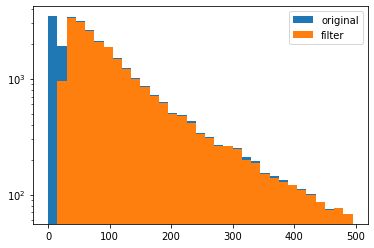

In [ ]:
import numpy as np    
import matplotlib.pyplot as plt
plt.hist(x_lens, bins=np.arange(0,500,15),log=True,label="original")
plt.hist(x_lens_f, bins=np.arange(0,500,15),log=True,label="filter")
plt.legend();

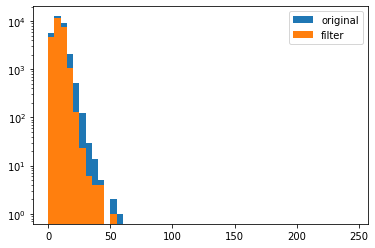

In [ ]:
import numpy as np    
import matplotlib.pyplot as plt
plt.hist(y_lens, bins=np.arange(0,250,5),log=True,label="original")
plt.hist(y_lens_f, bins=np.arange(0,250,5),log=True,label="filter")
plt.legend();

In [ ]:
x_train[0:25]

['functiondef args1 arguments arg constant str assign name store args0 attribute name load load assign name store args0 name load keyword str keyword str call args1 attribute attribute name load load load name load with withitem args1 attribute name load load name load call args0 attribute attribute name load load load createinstancecore(self: freezable) -> freezable\n',
 'functiondef args2 arguments arg arg constant str assign name store subscript args1 attribute attribute name load load load name load index unaryop usub int load if unaryop not name load return args0 name load assign name store args1 attribute attribute name load load load name load if unaryop not name load return args0 name load return args0 name load keyword args0 attribute name load load name load find rel=""homepage"" and rel=""download"" links in `page`\n',
 'functiondef args10 arguments arg arg arg arg arg arg arg arg arg arg nonetype nonetype str str nonetype int bool constant str assign name store args1 name l

In [ ]:
y_train[0:25]

['test sequencing center can be created with out name\n',
 'only ever yields unique items\n',
 'otherwise check if credentials is not none and uses them and\n',
 'l transformjsonobject transforms l list s\n',
 'displays specified message on button to let user know the action is in progress threadsafe\n',
 'creates examples for the training and dev sets\n',
 'it assumes data has the structure of a dictionary which maps orders executor instance to orders which need\n',
 'other metadata linked to agent removal\n',
 'split a data file into dict of header and sections\n',
 'generate all atomic orbital names that could be used by molpro\n',
 'return n distinct plot objects\n',
 'stores the index size tuple for the pack in the index sizes\n',
 'tests detectinvalid over the consensys benchmark suite\n',
 'interface address then the test won t be able to stop the reactor being\n',
 'r class float or numpy ndarray\n',
 'of the provided curve s order\n',
 'is greater than max size and the url is 

In [ ]:
x_max_text_len = 300 #300 #140 #142 #142
y_max_text_len = 10 #50 #30
x_max_words = 200 #30000 #100 #15000 #31000 
y_max_words = 30000 #20000 #14500 #20000 #26000 #35000 #33000
y_min_occ = 0 #2

In [ ]:
import time

open('x_train.txt', 'w').close()
with open(os.path.join(coding_dir, 'x_train.txt'), 'a+') as datafile:
  datafile.writelines(x_train)
  print(len(x_train))

open('y_train.txt', 'w').close()
with open(os.path.join(coding_dir, 'y_train.txt'), 'a+') as datafile:
  datafile.writelines(y_train)
  print(len(y_train))

open('x_val.txt', 'w').close()
with open(os.path.join(coding_dir, 'x_val.txt'), 'a+') as datafile:
  datafile.writelines(x_val)
  print(len(x_val))

open('y_val.txt', 'w').close()
with open(os.path.join(coding_dir, 'y_val.txt'), 'a+') as datafile:
  datafile.writelines(y_val)
  print(len(y_val))

open('x_test.txt', 'w').close()
with open(os.path.join(coding_dir, 'x_test.txt'), 'a+') as datafile:
  datafile.writelines(x_test)
  print(len(x_test))

open('y_test.txt', 'w').close()
with open(os.path.join(coding_dir, 'y_test.txt'), 'a+') as datafile:
  datafile.writelines(y_test)
  print(len(y_test))

20250
20250
2250
2250
2500
2500


In [ ]:
dataset.setOutput('y_train.txt',
             'train',
             type='text',
             id='target_text',
             tokenization=tokenize_y,
             build_vocabulary=True,
             pad_on_batch=True,
             sample_weights=True,
             max_text_len=y_max_text_len,
             max_words=y_max_words,
             min_occ=y_min_occ)

dataset.setOutput('y_val.txt',
             'val',
             type='text',
             id='target_text',
             pad_on_batch=True,
             tokenization=tokenize_y,
             sample_weights=True,
             max_text_len=y_max_text_len,
             max_words=y_max_words)

[13/08/2020 04:26:10] 	Applying tokenization function: "tokenize_none".
[13/08/2020 04:26:10] Creating vocabulary for data with data_id 'target_text'.
[13/08/2020 04:26:10] 	 Total: 14289 unique words in 20250 sentences with a total of 165019 words.
[13/08/2020 04:26:10] Creating dictionary of 30000 most common words, covering 100.0% of the text.
[13/08/2020 04:26:10] Loaded "train" set outputs of data_type "text" with data_id "target_text" and length 20250.
[13/08/2020 04:26:10] 	Applying tokenization function: "tokenize_none".
[13/08/2020 04:26:10] Loaded "val" set outputs of data_type "text" with data_id "target_text" and length 2250.


In [ ]:
dataset.setInput('x_train.txt',
            'train',
            type='text',
            id='source_text',
            pad_on_batch=True,
            tokenization=tokenize_x,
            build_vocabulary=True,
            fill='end',
            max_text_len=x_max_text_len,
            max_words=x_max_words,
            min_occ=0)

dataset.setInput('x_val.txt',
            'val',
            type='text',
            id='source_text',
            pad_on_batch=True,
            tokenization=tokenize_x,
            fill='end',
            max_text_len=x_max_text_len,
            min_occ=0)

[13/08/2020 04:26:10] 	Applying tokenization function: "tokenize_none".
[13/08/2020 04:26:11] Creating vocabulary for data with data_id 'source_text'.
[13/08/2020 04:26:12] 	 Total: 19185 unique words in 20250 sentences with a total of 3100639 words.
[13/08/2020 04:26:12] Creating dictionary of 200 most common words, covering 98.0% of the text.
[13/08/2020 04:26:12] Loaded "train" set inputs of data_type "text" with data_id "source_text" and length 20250.
[13/08/2020 04:26:12] 	Applying tokenization function: "tokenize_none".
[13/08/2020 04:26:12] Loaded "val" set inputs of data_type "text" with data_id "source_text" and length 2250.


Similarly, we introduce the source text data, with the setInputs function. Again, when building the training split, we must construct the vocabulary.

...and for the 'state_below' data. Note that: 1) The offset flat is set to 1, which means that the text will be shifted to the right 1 position. 2) During sampling time, we won't have this input. Hence, we 'hack' the dataset model by inserting an artificial input, of type 'ghost' for the validation split.

In [ ]:
dataset.setInput('y_train.txt',
            'train',
            type='text',
            id='state_below',
            required=False,
            tokenization=tokenize_y,
            pad_on_batch=True,
            build_vocabulary='target_text',
            offset=1,
            fill='end',
            max_text_len=y_max_text_len,
            max_words=y_max_words)
dataset.setInput(None,
            'val',
            type='ghost',
            id='state_below',
            required=False)

[13/08/2020 04:26:12] 	Applying tokenization function: "tokenize_none".
[13/08/2020 04:26:12] 	Reusing vocabulary named "target_text" for data with data_id "state_below".
[13/08/2020 04:26:12] Loaded "train" set inputs of data_type "text" with data_id "state_below" and length 20250.
[13/08/2020 04:26:12] Loaded "val" set inputs of data_type "ghost" with data_id "state_below" and length 2250.


We can also keep the literal source words (for replacing unknown words).

In [ ]:
for split, input_text_filename in zip(['train', 'val'], ['x_train.txt','x_val.txt']):
  dataset.setRawInput(input_text_filename,
                split,
                type='file-name',
                id='raw_source_text',
                overwrite_split=True)

[13/08/2020 04:26:13] Loaded "train" set inputs of type "file-name" with id "raw_source_text".
[13/08/2020 04:26:13] Loaded "val" set inputs of type "file-name" with id "raw_source_text".


We also need to match the references with the inputs. Since we only have one reference per input sample, we set `repeat=1`.

In [ ]:
keep_n_captions(dataset, repeat=1, n=1, set_names=['val'])

[13/08/2020 04:26:13] Keeping 1 captions per input on the val set.
[13/08/2020 04:26:13] Samples reduced to 2250 in val set.


Finally, we can save our dataset instance for using in other experiments:

In [ ]:
saveDataset(dataset, 'datasets')

[13/08/2020 04:26:13] <<< Saving Dataset instance to datasets/Dataset_tutorial_dataset.pkl ... >>>
[13/08/2020 04:26:13] <<< Dataset instance saved >>>


## 2. Creating and training a Neural Translation Model
Now, we'll create and train a Neural Machine Translation (NMT) model. Since there is a significant number of hyperparameters, we'll use the default ones, specified in the `config.py` file. Note that almost every hardcoded parameter is automatically set from config if we run  `main.py `.

We'll create an `'AttentionRNNEncoderDecoder'` (a LSTM encoder-decoder with attention mechanism). Refer to the [`model_zoo.py`](https://github.com/lvapeab/nmt-keras/blob/master/nmt_keras/model_zoo.py) file for other models (e.g. Transformer). 

So first, let's import the model and the hyperparameters. We'll also load the dataset we stored in the previous section (not necessary as it is in memory, but as a demonstration):

In [ ]:
os.chdir(coding_dir)
os.chdir('nmt-keras')

from config import load_parameters
from nmt_keras.model_zoo import TranslationModel
from keras_wrapper.cnn_model import loadModel
from keras_wrapper.dataset import loadDataset
from keras_wrapper.extra.callbacks import PrintPerformanceMetricOnEpochEndOrEachNUpdates
params = load_parameters()
os.chdir(coding_dir)
dataset = loadDataset('datasets/Dataset_tutorial_dataset.pkl')

[13/08/2020 04:26:16] <<< Loading Dataset instance from datasets/Dataset_tutorial_dataset.pkl ... >>>
[13/08/2020 04:26:16] <<< Dataset instance loaded >>>


Since the number of words in the dataset may be unknown beforehand, we must update the params information according to the dataset instance:


In [ ]:
params['num_examples'] = num_examples
params['y_max_text_len'] = y_max_text_len
params['x_max_text_len'] = x_max_text_len
params['tokenize_x'] = tokenize_x
params['tokenize_y'] = tokenize_y
params['x_max_words'] = x_max_words
params['y_max_words'] = y_max_words
params['y_min_occ'] = y_min_occ

In [ ]:
import datetime
with open(f'indices-{datetime.datetime.now()}','a+') as indices_file:
  indices_file.write(",".join([str(i) for i in list(indices)]))

In [ ]:
#  Supported models: 'AttentionRNNEncoderDecoder' and 'Transformer'.
params['MODEL_TYPE'] = 'AttentionRNNEncoderDecoder'
# params['MODEL_TYPE'] = 'Transformer'

In [ ]:
params['INPUT_VOCABULARY_SIZE'] = dataset.vocabulary_len['source_text']
params['OUTPUT_VOCABULARY_SIZE'] = dataset.vocabulary_len['target_text']
is_transformer = params.get('ATTEND_ON_OUTPUT', 'transformer' in params['MODEL_TYPE'].lower())

In [ ]:
drop_p = 0.0 #0.2
# if not is_transformer:
#   params['RECURRENT_INPUT_DROPOUT_P'] = drop_p              
#   params['RECURRENT_DROPOUT_P'] = drop_p
# else:
#   params['DROPOUT_P'] = drop_p

params['ATTENTION_DROPOUT_P'] = drop_p
params['DROPOUT_P'] = drop_p
params['USE_BATCH_NORMALIZATION'] = not drop_p      


params['USE_CUDNN'] = tf.test.is_gpu_available()
params['N_GPUS'] = 1 if tf.test.is_gpu_available() else 0
params['BEAM_SIZE'] = beam_size
params['TOKENIZATION_METHOD'] = tokenize_x
params['MAX_INPUT_TEXT_LEN'] = x_max_text_len
params['MAX_OUTPUT_TEXT_LEN'] = y_max_text_len
params['INPUT_VOCABULARY_SIZE'] = min(len(dataset.vocabulary['source_text']['idx2words']),x_max_words)
params['OUTPUT_VOCABULARY_SIZE'] = min(len(dataset.vocabulary['target_text']['idx2words']),y_max_words)
params['SRC_LAN'] = "ast"
params['TRG_LAN'] = "en"
params['MAXLEN_GIVEN_X'] = False
params['MINLEN_GIVEN_X'] = False
params['DATASET_NAME'] = 'ASTDocstring'

params['TASK_NAME'] = params['DATASET_NAME']
params['DATA_ROOT_PATH'] = ""
params['PATIENCE'] = 3
params['PLOT_EVALUATION'] = True
params['LABEL_SMOOTHING'] = 0.1

params['KERAS_METRICS'] = ['perplexity'] 
params['EVAL_ON_SETS'] = ['train','val']
params['EPOCHS_FOR_SAVE'] = 5

if not is_transformer:
  params['BATCH_SIZE'] = batch_size
  size_num = 512 
  params['SOURCE_TEXT_EMBEDDING_SIZE'] = size_num #64
  params['TARGET_TEXT_EMBEDDING_SIZE'] = size_num #//4 #64
  params['ENCODER_HIDDEN_SIZE'] = size_num #64
  params['DECODER_HIDDEN_SIZE'] = size_num #64
  params['ATTENTION_SIZE'] = params['DECODER_HIDDEN_SIZE']
  n_layers = 2
  params['N_LAYERS_ENCODER'] = n_layers
  params['N_LAYERS_DECODER'] = n_layers
  params['SKIP_VECTORS_HIDDEN_SIZE'] = params['TARGET_TEXT_EMBEDDING_SIZE']
  params['DEEP_OUTPUT_LAYERS'] = [('linear', size_num)] #64)]
  params['MODEL_SIZE'] = size_num #64
else:
  params['BATCH_SIZE'] = batch_size
  size_num = 512
  params['SOURCE_TEXT_EMBEDDING_SIZE'] = size_num #64
  params['TARGET_TEXT_EMBEDDING_SIZE'] = size_num
  params['ENCODER_HIDDEN_SIZE'] = size_num #64
  params['DECODER_HIDDEN_SIZE'] = size_num #64
  params['ATTENTION_SIZE'] = params['DECODER_HIDDEN_SIZE']
  params['N_HEADS'] = 4
  n_layers = 3
  params['N_LAYERS_ENCODER'] = n_layers
  params['N_LAYERS_DECODER'] = n_layers
  params['SKIP_VECTORS_HIDDEN_SIZE'] = params['TARGET_TEXT_EMBEDDING_SIZE']
  params['DEEP_OUTPUT_LAYERS'] = [('linear', size_num)] #64)]
  params['MODEL_SIZE'] = size_num #64
  # params['ATTENTION_MODE'] = 'dot'

# params['NORMALIZE_SAMPLING'] = True
# params['SEARCH_PRUNING'] = True
params['LENGTH_PENALTY'] = True
params['COVERAGE_PENALTY'] = True

params['OPTIMIZER'] = 'Adam'
if params['OPTIMIZER'] == 'SGD':
  params['LR'] = 0.01
  params['LR_REDUCE_EACH_EPOCHS'] = True
  params['LR_DECAY'] = 1
elif params['OPTIMIZER'] == 'Adam':
  params['LR'] = 0.0002 #0.001
#NOTE: model_size must == embed_size

In [ ]:
def set_model_name(params):
  if params['MODEL_TYPE'] == 'AttentionRNNEncoderDecoder':
    return params['TASK_NAME'] + '_' + params['SRC_LAN'] + params['TRG_LAN'] + '_' + params['MODEL_TYPE'] + \
      '_src_emb_' + str(params['SOURCE_TEXT_EMBEDDING_SIZE']) + \
      '_bidir_' + str(params['BIDIRECTIONAL_ENCODER']) + \
      '_enc_' + params['ENCODER_RNN_TYPE'] + '_' + str(params['ENCODER_HIDDEN_SIZE']) + \
      '_dec_' + params['DECODER_RNN_TYPE'] + '_' + str(params['DECODER_HIDDEN_SIZE']) + \
      '_deepout_' + '_'.join([layer[0] for layer in params['DEEP_OUTPUT_LAYERS']]) + \
      '_trg_emb_' + str(params['TARGET_TEXT_EMBEDDING_SIZE']) + \
      '_' + params['OPTIMIZER'] + '_' + str(params['LR'])
  elif params['MODEL_NAME'] == 'Transformer':
    return params['TASK_NAME'] + '_' + params['SRC_LAN'] + params['TRG_LAN'] + '_' + params['MODEL_TYPE'] + \
              '_model_size_' + str( params['MODEL_SIZE']) + \
              '_ff_size_' + str( params['FF_SIZE']) + \
              '_num_heads_' + str( params['N_HEADS']) + \
              '_encoder_blocks_' + str( params['N_LAYERS_ENCODER']) + \
              '_decoder_blocks_' + str( params['N_LAYERS_DECODER']) + \
              '_deepout_' + '_'.join([layer[0] for layer in params['DEEP_OUTPUT_LAYERS']]) + \
              '_' +  params['OPTIMIZER'] + '_' + str(params['LR'])
  else:
    return params['TASK_NAME'] + '_' + params['SRC_LAN'] + params['TRG_LAN'] + '_' +\
                  params['MODEL_TYPE']  + '_' + params['OPTIMIZER'] + '_' + str(params['LR'])

params['MODEL_NAME'] = set_model_name(params)

Now, we create a `TranslationModel` instance:


In [ ]:
nmt_model = TranslationModel(params,
                             model_type=params['MODEL_TYPE'], 
                             model_name='tutorial_model',
                             vocabularies=dataset.vocabulary,
                             store_path='trained_models/tutorial_model/',
                             verbose=True)

[13/08/2020 04:26:17] <<< Building AttentionRNNEncoderDecoder Translation_Model >>>


[13/08/2020 04:26:17] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:650: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



[13/08/2020 04:26:17] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4786: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



[13/08/2020 04:26:17] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:157: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


[13/08/2020 04:26:21] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3561: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


-----------------------------------------------------------------------------------
		TranslationModel instance
-----------------------------------------------------------------------------------
_model_type: AttentionRNNEncoderDecoder
name: tutorial_model
model_path: trained_models/tutorial_model/
verbose: True

Params:
	ACCUMULATE_GRADIENTS: 1
	ADDITIONAL_OUTPUT_MERGE_MODE: Add
	ALIGN_FROM_RAW: True
	ALPHA_FACTOR: 0.6
	AMSGRAD: False
	APPLY_DETOKENIZATION: False
	ATTENTION_DROPOUT_P: 0.0
	ATTENTION_MODE: add
	ATTENTION_SIZE: 512
	BATCH_NORMALIZATION_MODE: 1
	BATCH_SIZE: 200
	BEAM_SEARCH: True
	BEAM_SIZE: 6
	BETA_1: 0.9
	BETA_2: 0.999
	BIDIRECTIONAL_DEEP_ENCODER: True
	BIDIRECTIONAL_ENCODER: True
	BIDIRECTIONAL_MERGE_MODE: concat
	BPE_CODES_PATH: examples/EuTrans//training_codes.joint
	CLASSIFIER_ACTIVATION: softmax
	CLIP_C: 5.0
	CLIP_V: 0.0
	COVERAGE_NORM_FACTOR: 0.2
	COVERAGE_PENALTY: True
	DATASET_NAME: ASTDocstring
	DATASET_STORE_PATH: datasets/
	DATA_AUGMENTATION: False
	DATA_ROO

[13/08/2020 04:26:23] From /content/drive/My Drive/Coding stuff/nmt-keras/nmt_keras/model_zoo.py:213: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.

[13/08/2020 04:26:23] Preparing optimizer and compiling. Optimizer configuration: 
	 LR: 0.0002
	 LOSS: categorical_crossentropy
	 BETA_1: 0.9
	 BETA_2: 0.999
	 EPSILON: 1e-08


[13/08/2020 04:26:23] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1192: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



In [ ]:
wandb.log({'params': params})

Next, we must define the inputs and outputs mapping from our Dataset instance to our model:


In [ ]:
inputMapping = dict()
for i, id_in in enumerate(params['INPUTS_IDS_DATASET']):
    pos_source = dataset.ids_inputs.index(id_in)
    id_dest = nmt_model.ids_inputs[i]
    inputMapping[id_dest] = pos_source
nmt_model.setInputsMapping(inputMapping)

outputMapping = dict()
for i, id_out in enumerate(params['OUTPUTS_IDS_DATASET']):
    pos_target = dataset.ids_outputs.index(id_out)
    id_dest = nmt_model.ids_outputs[i]
    outputMapping[id_dest] = pos_target
nmt_model.setOutputsMapping(outputMapping)

We can add some callbacks for controlling the training (e.g. Sampling each N updates, early stop, learning rate annealing...). For instance, let's build a sampling callback. After each epoch, it will compute the BLEU scores on the development set using the sacreBLEU package. We need to pass some configuration variables to the callback (in the extra_vars dictionary):


In [ ]:
search_params = {
    'language': 'en',
    'tokenize_f': eval('dataset.' + tokenize_x),
    'beam_size': beam_size,
    'optimized_search': True,
    'model_inputs': params['INPUTS_IDS_MODEL'],
    'model_outputs': params['OUTPUTS_IDS_MODEL'],
    'dataset_inputs':  params['INPUTS_IDS_DATASET'],
    'dataset_outputs':  params['OUTPUTS_IDS_DATASET'],
    'n_parallel_loaders': n_parallel_loaders,
    'maxlen': y_max_text_len,
    'normalize_probs': True,
    'pos_unk': True and not is_transformer,  # Pos_unk is unimplemented for transformer models
    'heuristic': 0,
    'state_below_maxlen': -1,
    'attend_on_output': is_transformer,
    'val': {'references': dataset.extra_variables['val']['target_text']}
  }

vocab = dataset.vocabulary['target_text']['idx2words']
callbacks = []
input_text_id = params['INPUTS_IDS_DATASET'][0]

callbacks.append(PrintPerformanceMetricOnEpochEndOrEachNUpdates(nmt_model,
                                                                dataset,
                                                                gt_id='target_text',
                                                                metric_name=['sacrebleu'],
                                                                set_name=['val'],
                                                                batch_size=batch_size,
                                                                each_n_epochs=1,
                                                                extra_vars=search_params,
                                                                reload_epoch=0,
                                                                is_text=True,
                                                                input_text_id=input_text_id,
                                                                index2word_y=vocab,
                                                                sampling_type='max_likelihood',
                                                                beam_search=True,
                                                                save_path=nmt_model.model_path,
                                                                start_eval_on_epoch=0,
                                                                write_samples=True,
                                                                write_type='list',
                                                                verbose=True))
callbacks.append(WandbCallback(monitor='Bleu_4',save_model=True))

Now we are ready to train. Let's set up some training parameters...


In [ ]:
n_epochs = 35
training_params = {'n_epochs': n_epochs,
                   'batch_size': batch_size,
                   'maxlen': y_max_text_len,
                   'epochs_for_save': 1,
                   'verbose': 1,
                   'eval_on_sets': [], 
                   'n_parallel_loaders': n_parallel_loaders,
                   'extra_callbacks': callbacks,
                   'reload_epoch': 0,
                   'epoch_offset': 0}

And train!


In [ ]:
nmt_model.trainNet(dataset, training_params)

[13/08/2020 04:26:29] <<< Training model >>>
[13/08/2020 04:26:29] Training parameters: { 
	batch_size: 200
	class_weights: None
	da_enhance_list: []
	da_patch_type: resize_and_rndcrop
	data_augmentation: False
	each_n_epochs: 1
	epoch_offset: 0
	epochs_for_save: 1
	eval_on_epochs: True
	eval_on_sets: []
	extra_callbacks: [<keras_wrapper.extra.callbacks.EvalPerformance object at 0x7fdae2760828>, <wandb.keras.WandbCallback object at 0x7fdae27607f0>]
	homogeneous_batches: False
	initial_lr: 1.0
	joint_batches: 4
	lr_decay: None
	lr_gamma: 0.1
	lr_half_life: 50000
	lr_reducer_exp_base: 0.5
	lr_reducer_type: linear
	lr_warmup_exp: -1.5
	maxlen: 10
	mean_substraction: False
	metric_check: None
	min_delta: 0.0
	min_lr: 1e-09
	n_epochs: 35
	n_gpus: 1
	n_parallel_loaders: 3
	normalization_type: None
	normalize: False
	num_iterations_val: None
	patience: 0
	patience_check_split: val
	reduce_each_epochs: True
	reload_epoch: 0
	shuffle: True
	start_eval_on_epoch: 0
	start_reduction_on_epoch: 0
	t

[13/08/2020 04:26:34] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3315: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



[13/08/2020 04:26:34] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:292: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.



[13/08/2020 04:26:34] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:299: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



[13/08/2020 04:26:34] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:312: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



[13/08/2020 04:26:34] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:321: The name tf.is_variable_initialized is deprecated. Please use tf.compat.v1.is_variable_initialized instead.

[13/08/2020 04:26:34] Starting dataLoad_process_0...
[13/08/2020 04:26:34] Starting dataLoad_process_1...
[13/08/2020 04:26:34] Starting dataLoad_process_2...


[13/08/2020 04:26:38] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:328: The name tf.variables_initializer is deprecated. Please use tf.compat.v1.variables_initializer instead.



Epoch 1/35


Process Process-3:
Traceback (most recent call last):
Process Process-4:
Process Process-2:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.6/dist-packages/keras_wrapper/dataset.py", line 51, in dataLoad
    while out_queue.qsize() > max_queue_len:
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/keras_wrapper/dataset.py", line 51, in dataLoad
    while out_queue.qsize() > max_queue_len:
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.6/dist

KeyboardInterrupt: ignored

In [ ]:
!nvidia-smi

## 3. Decoding with a trained Neural Machine Translation Model

Now, we'll load from disk the model we just trained and we'll apply it for translating new text. In this case, we want to translate the 'test' split from our dataset.

Since we want to translate a new data split ('test') we must add it to the dataset instance, just as we did before (at the first tutorial). In case we also had the refences of the test split and we wanted to evaluate it, we can add it to the dataset. Note that this is not mandatory and we could just predict without evaluating.

In [ ]:
dataset.setInput('x_test.txt',
            'test',
            type='text',
            id='source_text',
            pad_on_batch=True,
            tokenization=tokenize_x,
            fill='end',
            max_text_len=x_max_text_len,
            min_occ=0)

dataset.setInput(None,
            'test',
            type='ghost',
            id='state_below',
            required=False)

dataset.setRawInput('x_test.txt',
              'test',
              type='file-name',
              id='raw_source_text',
              overwrite_split=True)

Now, let's load the translation model. Suppose we want to load the model saved at the end of the epoch 4:


In [ ]:
params['INPUT_VOCABULARY_SIZE'] = dataset.vocabulary_len[params['INPUTS_IDS_DATASET'][0]]
params['OUTPUT_VOCABULARY_SIZE'] = dataset.vocabulary_len[params['OUTPUTS_IDS_DATASET'][0]]

# Load model
#n_epochs
epoch_load = -1
try:
  nmt_model = loadModel(os.path.join(coding_dir,'trained_models/tutorial_model'),n_epochs)
  epoch_load = n_epochs
except:
  epoch_load = 10
  nmt_model = loadModel(os.path.join(coding_dir,'trained_models/tutorial_model'),epoch_load)

Once we loaded the model, we just have to invoke the sampling method (in this case, the Beam Search algorithm) for the 'test' split:


In [ ]:
is_transformer = params.get('ATTEND_ON_OUTPUT', 'transformer' in params['MODEL_TYPE'].lower())

params_prediction = {
    'language': 'en',
    'tokenize_f': eval('dataset.' + tokenize_x),
    'beam_size': beam_size,
    'optimized_search': True,
    'model_inputs': params['INPUTS_IDS_MODEL'],
    'model_outputs': params['OUTPUTS_IDS_MODEL'],
    'dataset_inputs':  params['INPUTS_IDS_DATASET'],
    'dataset_outputs':  params['OUTPUTS_IDS_DATASET'],
    'n_parallel_loaders': n_parallel_loaders,
    'maxlen': y_max_text_len,
    'normalize_probs': True,
    'pos_unk': True and not is_transformer,
    'heuristic': 0,
    'state_below_maxlen': -1,
    'predict_on_sets': ['test'],
    'verbose': 0,
    'attend_on_output': is_transformer
  }
predictions = nmt_model.predictBeamSearchNet(dataset, params_prediction)['test']

Up to now, in the variable 'predictions', we have the indices of the words of the hypotheses. We must decode them into words. For doing this, we'll use the dictionary stored in the dataset object:


In [ ]:
from keras_wrapper.utils import decode_predictions_beam_search
vocab = dataset.vocabulary['target_text']['idx2words']
samples = predictions['samples'] # Get word indices from the samples.

predictions = decode_predictions_beam_search(samples,  
                                             vocab,
                                             verbose=params['VERBOSE'])

Finally, we store the hypotheses:



In [ ]:
filepath = 'test.pred'
from keras_wrapper.extra.read_write import list2file
list2file(filepath, predictions)
!head -n 20 test.pred

If we have the references of this split, we can also evaluate the performance of our system on it. First, we must add them to the dataset object:


In [ ]:
dataset.setOutput('y_test.txt',
             'test',
             type='text',
             id='target_text',
             pad_on_batch=True,
             tokenization=tokenize_y,
             sample_weights=True,
             max_text_len=y_max_text_len,
             max_words=y_max_words)
keep_n_captions(dataset, repeat=1, n=1, set_names=['test'])

Next, we call the evaluation system: the sacreBLEU package:


In [ ]:
from keras_wrapper.extra.evaluation import select
metric = 'sacrebleu'
# Apply sampling
extra_vars = dict()
extra_vars['tokenize_f'] = eval('dataset.' + tokenize_x)
extra_vars['language'] = params['TRG_LAN']
extra_vars['test'] = dict()
extra_vars['test']['references'] = dataset.extra_variables['test']['target_text']
metrics = select[metric](pred_list=predictions,
                                          verbose=1,
                                          extra_vars=extra_vars,
                                          split='test')

In [ ]:
wandb.log({'BLEU_4_TEST': metrics['Bleu_4']})

And that's all!